M Kronig (23029039)

CSC-40098 Final Project

Analysis of posts from the CS Educators Stack Exchange website
(SS3) What questions are computer science educators asking?

Installing packages needed for the project

In [2]:
# Importing packages needed for project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter
from wordcloud import WordCloud

import random
from hdbscan import HDBSCAN
from umap import UMAP
from bertopic import BERTopic

# Setting the random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

/Users/matthewkronig/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/matthewkronig/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Reading the data into a Pandas dataframe

In [3]:
# Reading the data into a Pandas dataframe
df = pd.read_csv('/Users/matthewkronig/Git/CSC-40098/CSED.csv')

Looking at the shape of the data, there are 6499 rows and 11 columns

In [4]:
# Looking a the shape of the data 
df.shape

(6499, 11)

Using the dataframe head() function to inspect the columns and a small set of the rows

In [5]:
df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,What autograding software do folks use for Jav...,<p>Grading currently either takes me a huge am...,9,5402.0,8.0,26,<java><grading><auto-graders>,2017-05-23 14:20:02
1,3,1,NaN,Is it possible to ensure division of labor on ...,<p>Let's say I've assigned my Intro to CS clas...,1,602.0,4.0,10,<group-work>,2017-05-23 14:20:35
2,4,1,NaN,Objects Lab Before Inheritance and Polymorphism,<p>I am finding it very difficult to create a ...,3,712.0,11.0,9,<object-oriented-paradigm><labs><ap-computer-s...,2017-05-23 14:21:14
3,6,1,NaN,Teaching Induction to Prove the Correctness of...,<p>This is a subject that I have had a lot of ...,1,413.0,3.0,8,<lesson-ideas><cs-theory><induction>,2017-05-23 14:24:14
4,7,1,NaN,Should the first Programming/Algorithms class ...,"<p>When I was studying, my professors had diff...",7,1404.0,9.0,22,<pseudo-code>,2017-05-23 14:25:23


Using the dtypes method to have a look a the the datatypes Pandas has assigned

In [6]:
df.dtypes

Id                int64
PostTypeId        int64
ParentId        float64
Title            object
Body             object
CommentCount      int64
ViewCount       float64
AnswerCount     float64
Score             int64
Tags             object
CreationDate     object
dtype: object

In [7]:
df.describe()

,Id,PostTypeId,ParentId,CommentCount,ViewCount,AnswerCount,Score
count,6499.000000,6499.000000,4786.000000,6499.00000,1250.000000,1250.000000,6499.000000
mean,4284.675181,1.986152,4015.998537,2.14156,1557.989600,3.828800,4.986459
std,2401.090579,0.811273,2454.415062,3.29656,4945.944223,3.948565,10.054123
min,2.000000,1.000000,2.000000,0.00000,7.000000,0.000000,-5.000000
25%,2689.500000,2.000000,1408.000000,0.00000,138.000000,1.000000,1.000000
50%,4437.000000,2.000000,4211.000000,1.00000,266.000000,3.000000,3.000000
75%,6321.500000,2.000000,6005.000000,3.00000,743.000000,5.000000,5.000000
max,8237.000000,7.000000,8227.000000,42.00000,108964.000000,31.000000,229.000000


Data Cleaning

1. Check for duplicates
2. Check for missing values
3. Remove time from creation date column & convert datatype to date
4. Standardise text for analysis

No rows are duplicated

In [8]:
df.loc[df.duplicated()]

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate


Checking for missing values

In [9]:
df.isna().sum()

Id                 0
PostTypeId         0
ParentId        1713
Title           5249
Body              52
CommentCount       0
ViewCount       5249
AnswerCount     5249
Score              0
Tags            5249
CreationDate       0
dtype: int64

There's some metadata that I don't need for now. So I need to clean the data to only inlcude the questions and answers, while keepig the relevant columns.

In [10]:
df['PostTypeId'].value_counts()

PostTypeId
2    4786
1    1250
5     231
4     231
7       1
Name: count, dtype: int64

Making a new dataframe qa_df (questions and answers dataframe)

In [11]:
# Remember to work with this new dataframe, not original df
qa_df = df[df['PostTypeId'].isin([1, 2])].copy()

In [12]:
qa_df['PostTypeId'].value_counts()

PostTypeId
2    4786
1    1250
Name: count, dtype: int64

The data numbers for missing values makes sense and matches the counts for PostTypeId 1 (Questions) and 2 (Answers). Questions will not will not have a parent ID
and answers will not have titles, tags, view counts and answer counts.

In [13]:
qa_df.isna().sum()

Id                 0
PostTypeId         0
ParentId        1250
Title           4786
Body               0
CommentCount       0
ViewCount       4786
AnswerCount     4786
Score              0
Tags            4786
CreationDate       0
dtype: int64

In [14]:
# New dataframe shape with removed rows
qa_df.shape

(6036, 11)

Next, convert CreationDate to date datatype as it's currently an object (string). Also, remove time as it's not needed.

In [15]:
#qa_df['CreationDate'] = pd.to_datetime(qa_df['CreationDate']) - This still kept the time which may clutter up the charts
qa_df['CreationDate'] = pd.to_datetime(qa_df['CreationDate']).dt.normalize()

In [16]:
qa_df.dtypes

Id                       int64
PostTypeId               int64
ParentId               float64
Title                   object
Body                    object
CommentCount             int64
ViewCount              float64
AnswerCount            float64
Score                    int64
Tags                    object
CreationDate    datetime64[ns]
dtype: object

In [17]:
# Checking the dataframe again
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,What autograding software do folks use for Jav...,<p>Grading currently either takes me a huge am...,9,5402.0,8.0,26,<java><grading><auto-graders>,2017-05-23
1,3,1,NaN,Is it possible to ensure division of labor on ...,<p>Let's say I've assigned my Intro to CS clas...,1,602.0,4.0,10,<group-work>,2017-05-23
2,4,1,NaN,Objects Lab Before Inheritance and Polymorphism,<p>I am finding it very difficult to create a ...,3,712.0,11.0,9,<object-oriented-paradigm><labs><ap-computer-s...,2017-05-23
3,6,1,NaN,Teaching Induction to Prove the Correctness of...,<p>This is a subject that I have had a lot of ...,1,413.0,3.0,8,<lesson-ideas><cs-theory><induction>,2017-05-23
4,7,1,NaN,Should the first Programming/Algorithms class ...,"<p>When I was studying, my professors had diff...",7,1404.0,9.0,22,<pseudo-code>,2017-05-23


Next I need to start working on the format of the string objects - currently formatted as HTML, as well as finding a sensible way of organising the Tags data. The Title data isn't stored in HTML so I'll check this as well.


1. Lowercase everything

2. Strip HTML

3. Remove punctuation?

4. Remove stop words ("the", "is", "and") etc

5. Tokenization (splitting text into words)

Removing HTML with function using BeautifulSoup

In [18]:

def clean_html(text):
     """
        Removes the HTML from the Posts to clear away unescessary tags for analysis using BeautifulSoup.

        Parameters:
        text (str): The HTML string to clean (e.g., post body or title).

        Returns:
        str: The cleaned text with HTML tags removed.
        If the input is NaN or not a valid string, it returns an empty string.
        """
     if pd.isna(text):
         return ""
     return BeautifulSoup(text, 'html.parser').get_text()


In [19]:
qa_df['Title'] = qa_df['Title'].apply(clean_html)
qa_df['Body'] = qa_df['Body'].apply(clean_html)

In [20]:
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,What autograding software do folks use for Jav...,Grading currently either takes me a huge amoun...,9,5402.0,8.0,26,<java><grading><auto-graders>,2017-05-23
1,3,1,NaN,Is it possible to ensure division of labor on ...,Let's say I've assigned my Intro to CS class t...,1,602.0,4.0,10,<group-work>,2017-05-23
2,4,1,NaN,Objects Lab Before Inheritance and Polymorphism,I am finding it very difficult to create a lab...,3,712.0,11.0,9,<object-oriented-paradigm><labs><ap-computer-s...,2017-05-23
3,6,1,NaN,Teaching Induction to Prove the Correctness of...,This is a subject that I have had a lot of tro...,1,413.0,3.0,8,<lesson-ideas><cs-theory><induction>,2017-05-23
4,7,1,NaN,Should the first Programming/Algorithms class ...,"When I was studying, my professors had differe...",7,1404.0,9.0,22,<pseudo-code>,2017-05-23


Making the Title and Body columns all lowercase

In [21]:
qa_df['Title'] = qa_df['Title'].str.lower() # Makes Title lowercase
qa_df['Body'] = qa_df['Body'].str.lower() # Makes Body lowercase

In [22]:
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,what autograding software do folks use for jav...,grading currently either takes me a huge amoun...,9,5402.0,8.0,26,<java><grading><auto-graders>,2017-05-23
1,3,1,NaN,is it possible to ensure division of labor on ...,let's say i've assigned my intro to cs class t...,1,602.0,4.0,10,<group-work>,2017-05-23
2,4,1,NaN,objects lab before inheritance and polymorphism,i am finding it very difficult to create a lab...,3,712.0,11.0,9,<object-oriented-paradigm><labs><ap-computer-s...,2017-05-23
3,6,1,NaN,teaching induction to prove the correctness of...,this is a subject that i have had a lot of tro...,1,413.0,3.0,8,<lesson-ideas><cs-theory><induction>,2017-05-23
4,7,1,NaN,should the first programming/algorithms class ...,"when i was studying, my professors had differe...",7,1404.0,9.0,22,<pseudo-code>,2017-05-23


Next, remove all punctuation from Title and Body columns

In [23]:
# Remove punctuation from both 'Title' and 'Body' columns
qa_df['Title'] = qa_df['Title'].str.translate(str.maketrans('', '', string.punctuation))
qa_df['Body'] = qa_df['Body'].str.translate(str.maketrans('', '', string.punctuation))


In [24]:
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,what autograding software do folks use for jav...,grading currently either takes me a huge amoun...,9,5402.0,8.0,26,<java><grading><auto-graders>,2017-05-23
1,3,1,NaN,is it possible to ensure division of labor on ...,lets say ive assigned my intro to cs class the...,1,602.0,4.0,10,<group-work>,2017-05-23
2,4,1,NaN,objects lab before inheritance and polymorphism,i am finding it very difficult to create a lab...,3,712.0,11.0,9,<object-oriented-paradigm><labs><ap-computer-s...,2017-05-23
3,6,1,NaN,teaching induction to prove the correctness of...,this is a subject that i have had a lot of tro...,1,413.0,3.0,8,<lesson-ideas><cs-theory><induction>,2017-05-23
4,7,1,NaN,should the first programmingalgorithms class b...,when i was studying my professors had differen...,7,1404.0,9.0,22,<pseudo-code>,2017-05-23


Part way through data cleaning:
1. 'should the first programmingalgorithms ...' - removing punctuation has caused an odd thing here with the / where two words are now joined - check this
2. The Tags column will need to be addressed as well - perhaps the same approach can be applied but I need to make sure that's the best way so that I don't lose anythign when analysing the tags data
3. Removing repeated common words like 'the', 'and' etc

In [25]:
# Setting stop words variable to english setting (NLTK)
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """
    Removes stopwords like 'The' 'And" etc for cleaner analysis

    Parameters: String of text in both the 'Title' and 'Body' columns containg stopwords

    Returns: Cleaned strings containing no stopwords, keeping the rest of the text
    """
    return ' '.join([word for word in text.split() if word not in stop_words])

qa_df['Title'] = qa_df['Title'].apply(remove_stopwords)
qa_df['Body'] = qa_df['Body'].apply(remove_stopwords)

In [26]:
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,autograding software folks use java code,grading currently either takes huge amount tim...,9,5402.0,8.0,26,<java><grading><auto-graders>,2017-05-23
1,3,1,NaN,possible ensure division labor group assignment,lets say ive assigned intro cs class first gro...,1,602.0,4.0,10,<group-work>,2017-05-23
2,4,1,NaN,objects lab inheritance polymorphism,finding difficult create lab objects java weve...,3,712.0,11.0,9,<object-oriented-paradigm><labs><ap-computer-s...,2017-05-23
3,6,1,NaN,teaching induction prove correctness algorithms,subject lot trouble clarifying students explai...,1,413.0,3.0,8,<lesson-ideas><cs-theory><induction>,2017-05-23
4,7,1,NaN,first programmingalgorithms class taught pseud...,studying professors different approaches teach...,7,1404.0,9.0,22,<pseudo-code>,2017-05-23


In [27]:
# Cleaning the tags column - separating the tags into lists instead of the <> 
def clean_tags(tags_string):
    """
    Cleans the 'Tags' Column, changing the <> separators and putting all tags in each column into a list

    Parameters: 'Tags' column containg post subject tags such as '<java>' to be cleaned

    Returns: Cleaned 'Tags' column, where any tags listed are collected and put into one list (per row)
    """
    if pd.isna(tags_string):
        return []
    return tags_string.strip().strip('<>').split('><')

qa_df['Tags'] = qa_df['Tags'].apply(clean_tags)


In [28]:
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate
0,2,1,NaN,autograding software folks use java code,grading currently either takes huge amount tim...,9,5402.0,8.0,26,"[java, grading, auto-graders]",2017-05-23
1,3,1,NaN,possible ensure division labor group assignment,lets say ive assigned intro cs class first gro...,1,602.0,4.0,10,[group-work],2017-05-23
2,4,1,NaN,objects lab inheritance polymorphism,finding difficult create lab objects java weve...,3,712.0,11.0,9,"[object-oriented-paradigm, labs, ap-computer-s...",2017-05-23
3,6,1,NaN,teaching induction prove correctness algorithms,subject lot trouble clarifying students explai...,1,413.0,3.0,8,"[lesson-ideas, cs-theory, induction]",2017-05-23
4,7,1,NaN,first programmingalgorithms class taught pseud...,studying professors different approaches teach...,7,1404.0,9.0,22,[pseudo-code],2017-05-23


Data is now cleaned. The next stage is to start the basic EDA, with some core stats about the dataset

In [29]:
# Looking at some of the core quantatative statistics - rounded to 2dp for easier readability
qa_df.describe().round(2)

,Id,PostTypeId,ParentId,CommentCount,ViewCount,AnswerCount,Score,CreationDate
count,6036.00,6036.00,4786.00,6036.00,1250.00,1250.00,6036.00,6036
mean,4422.56,1.79,4016.00,2.31,1557.99,3.83,5.37,2019-03-29 02:43:25.168986112
min,2.00,1.00,2.00,0.00,7.00,0.00,-5.00,2017-05-23 00:00:00
25%,2827.75,2.00,1408.00,0.00,138.00,1.00,1.00,2017-07-21 00:00:00
50%,4636.50,2.00,4211.00,1.00,266.00,3.00,3.00,2018-04-17 00:00:00
75%,6419.25,2.00,6005.00,3.00,743.00,5.00,6.00,2020-07-06 00:00:00
max,8237.00,2.00,8227.00,42.00,108964.00,31.00,229.00,2025-03-27 00:00:00
std,2375.61,0.41,2454.42,3.36,4945.94,3.95,10.33,NaN


Key insights I want to start with (Before analysing any text):

Number of Posts per year shows that there has been a decline in the total number of posts each year, with the most being in 2017 when the CS ED Stack Exchange page launched. It's important to take into account that the data for 2025 is not a full year yet.

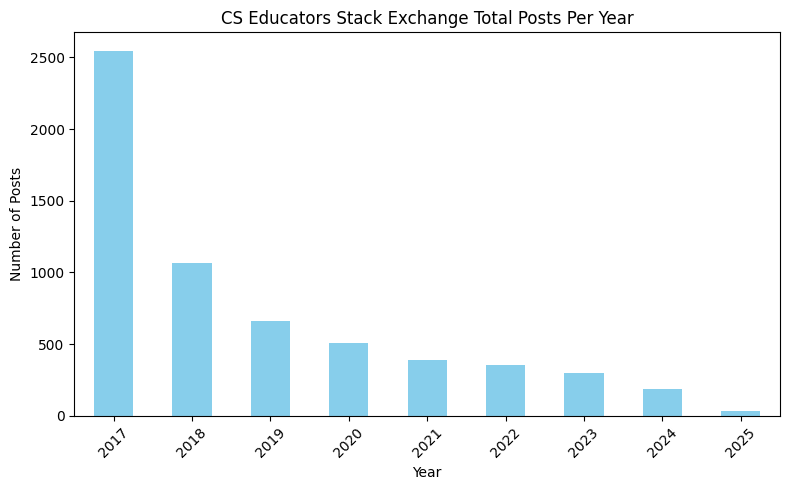

In [30]:
# Group by year and count
posts_per_year = qa_df.groupby(qa_df['CreationDate'].dt.year).size()

# Plotting the results - bar
posts_per_year.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.title('CS Educators Stack Exchange Total Posts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid = False
plt.tight_layout()
plt.show()

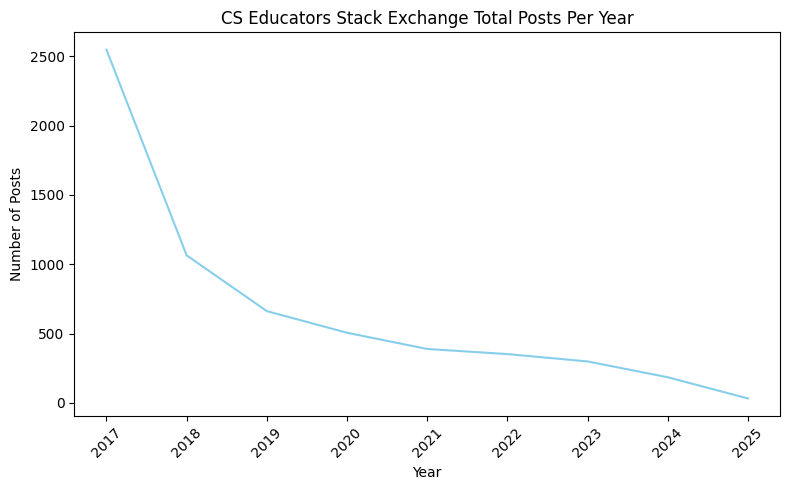

In [31]:
# Plotting the results - line
posts_per_year.plot(kind='line', figsize=(8,5), color='skyblue')
plt.title('CS Educators Stack Exchange Total Posts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid = False
plt.tight_layout()
plt.show()

Now I need to start analysing the text. It's prepared now, and so I need to start to transform it to be analysed.

In [32]:
# test code for tokenising
example = qa_df['Body'][0]
print(example)

word_tokenize(example)

grading currently either takes huge amount time gets done extremely cursory way occurs students able submit code sort autotester would find many errors review code would mean would look clarity issues logic bugs interested software isnt hard set b allow students test whether code least spec c allows quickly cycle code students section look style issues looked far wide yet found reasonable system accomplishes three goals many universities seem robust systems appear homegrown unavailable outsiders anyone aware system honestly dont even care costs money need solution makes task reasonable


['grading',
 'currently',
 'either',
 'takes',
 'huge',
 'amount',
 'time',
 'gets',
 'done',
 'extremely',
 'cursory',
 'way',
 'occurs',
 'students',
 'able',
 'submit',
 'code',
 'sort',
 'autotester',
 'would',
 'find',
 'many',
 'errors',
 'review',
 'code',
 'would',
 'mean',
 'would',
 'look',
 'clarity',
 'issues',
 'logic',
 'bugs',
 'interested',
 'software',
 'isnt',
 'hard',
 'set',
 'b',
 'allow',
 'students',
 'test',
 'whether',
 'code',
 'least',
 'spec',
 'c',
 'allows',
 'quickly',
 'cycle',
 'code',
 'students',
 'section',
 'look',
 'style',
 'issues',
 'looked',
 'far',
 'wide',
 'yet',
 'found',
 'reasonable',
 'system',
 'accomplishes',
 'three',
 'goals',
 'many',
 'universities',
 'seem',
 'robust',
 'systems',
 'appear',
 'homegrown',
 'unavailable',
 'outsiders',
 'anyone',
 'aware',
 'system',
 'honestly',
 'dont',
 'even',
 'care',
 'costs',
 'money',
 'need',
 'solution',
 'makes',
 'task',
 'reasonable']

So now I'll tokenize the dataset (Title and Body)

In [33]:
# Tokenising the Title and Body columns for easier analysis
qa_df['TitleTokens'] = qa_df['Title'].apply(word_tokenize)
qa_df['BodyTokens'] = qa_df['Body'].apply(word_tokenize)

Looking at the head now, ther are two new columns that contain the tokenised Title and Body columns, which I've renames TitleTokens and BodyTokens respectively. I want to keep the original separate for now

In [34]:
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate,TitleTokens,BodyTokens
0,2,1,NaN,autograding software folks use java code,grading currently either takes huge amount tim...,9,5402.0,8.0,26,"[java, grading, auto-graders]",2017-05-23,"[autograding, software, folks, use, java, code]","[grading, currently, either, takes, huge, amou..."
1,3,1,NaN,possible ensure division labor group assignment,lets say ive assigned intro cs class first gro...,1,602.0,4.0,10,[group-work],2017-05-23,"[possible, ensure, division, labor, group, ass...","[lets, say, ive, assigned, intro, cs, class, f..."
2,4,1,NaN,objects lab inheritance polymorphism,finding difficult create lab objects java weve...,3,712.0,11.0,9,"[object-oriented-paradigm, labs, ap-computer-s...",2017-05-23,"[objects, lab, inheritance, polymorphism]","[finding, difficult, create, lab, objects, jav..."
3,6,1,NaN,teaching induction prove correctness algorithms,subject lot trouble clarifying students explai...,1,413.0,3.0,8,"[lesson-ideas, cs-theory, induction]",2017-05-23,"[teaching, induction, prove, correctness, algo...","[subject, lot, trouble, clarifying, students, ..."
4,7,1,NaN,first programmingalgorithms class taught pseud...,studying professors different approaches teach...,7,1404.0,9.0,22,[pseudo-code],2017-05-23,"[first, programmingalgorithms, class, taught, ...","[studying, professors, different, approaches, ..."


I can now do some core analysis on the text in both the TitleTokens and BodyTokens columns, as well as the tags to start to get an idea of what the data is saying. A few things I want to know firstly:

1. What are the most common words appearing in the Titles and Posts? (Frequency analysis) with a word cloud as well as summary
2. What are the common themes/topics?
3. Which are the most common tags(topics) that are used?

Here we can see that we have the top 20 most frequent words in the Titles column (TitleTokens). Programming is the most common, follwed very closely by Students, then Teaching

In [35]:
# Find out the most common words in titles
all_title_tokens = [token for tokens in qa_df['TitleTokens'] for token in tokens]
Counter(all_title_tokens).most_common(20) # I'm starting with the most common 20 words initially

[('programming', 161),
 ('students', 157),
 ('teaching', 128),
 ('cs', 101),
 ('computer', 100),
 ('teach', 83),
 ('science', 74),
 ('course', 65),
 ('good', 61),
 ('learning', 60),
 ('code', 52),
 ('learn', 50),
 ('language', 49),
 ('use', 48),
 ('java', 37),
 ('best', 37),
 ('c', 37),
 ('student', 37),
 ('school', 33),
 ('class', 30)]

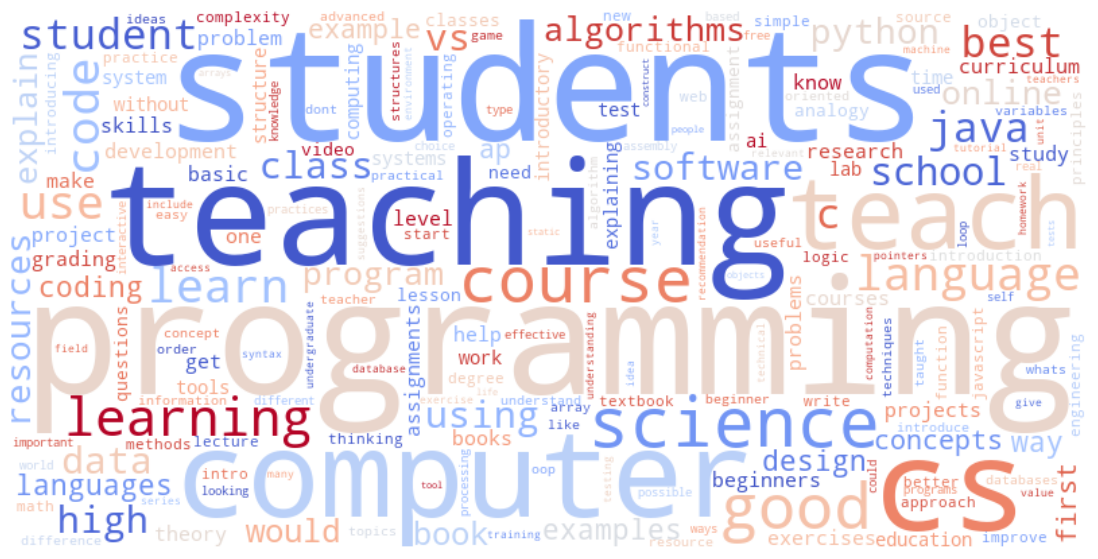

In [36]:
# Making a variable for teh counter of Title frequencies
word_freq = Counter(all_title_tokens)

# Build out the wordcloud chart
wc = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate_from_frequencies(word_freq)

# Plot and display 
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The Word Cloud is a good way to see immediately and clearly which words appear most frequently, I've added a bar chart to put them in order

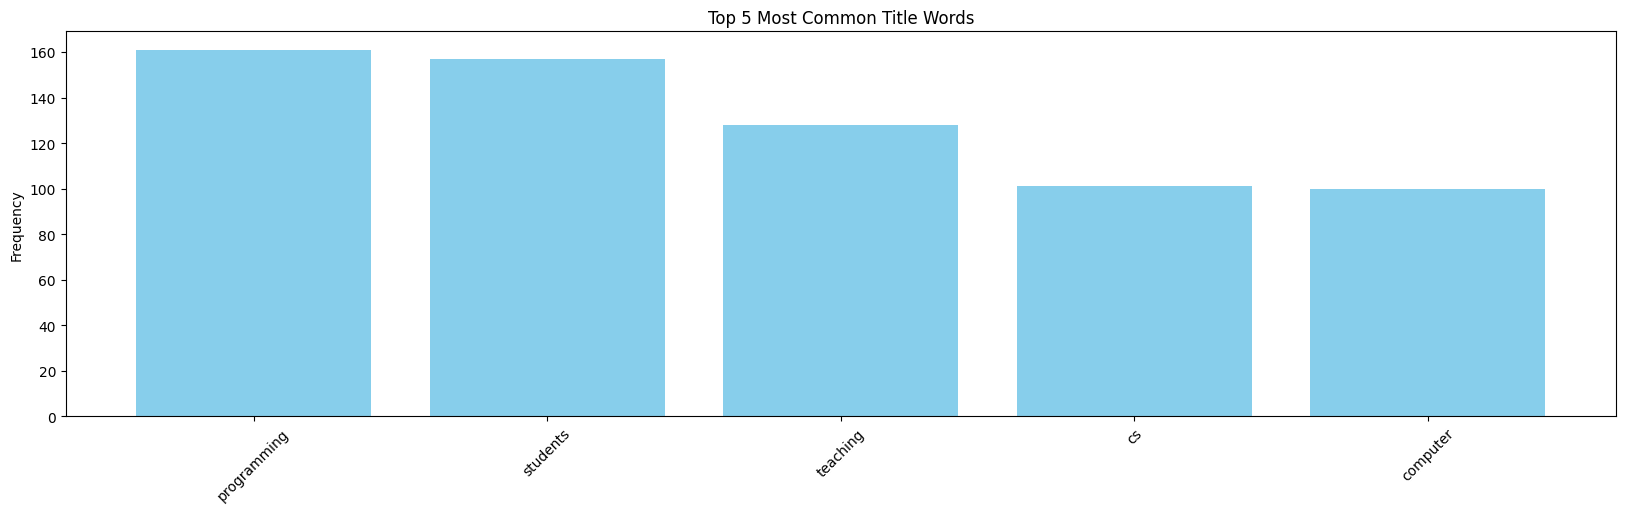

In [37]:
# Get the 20 most common words
most_common = word_freq.most_common(5)
words, counts = zip(*most_common)

# Making the plot
plt.figure(figsize=(20, 5))
plt.bar(words, counts, color='skyblue')
plt.title("Top 5 Most Common Title Words")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()

Now, I'll apply the same methods to the 'Body' column. There are still a lot of common words appearing frequently that probably won't add much value to my analysis, so I may need to find a way to filter these out as well. 'students' is still high up, as is 'code' and 'programming'

In [38]:
# Find out the most common words in Body column
all_body_tokens = [token for tokens in qa_df['BodyTokens'] for token in tokens]
Counter(all_body_tokens).most_common(20)

[('students', 9021),
 ('one', 5166),
 ('code', 4579),
 ('programming', 4286),
 ('like', 4243),
 ('use', 4177),
 ('would', 4147),
 ('also', 3599),
 ('work', 3132),
 ('get', 3093),
 ('course', 3083),
 ('dont', 3050),
 ('time', 3010),
 ('language', 2887),
 ('need', 2860),
 ('make', 2797),
 ('first', 2741),
 ('way', 2689),
 ('computer', 2627),
 ('good', 2611)]

In [39]:
# Start with default stopwords
custom_stopwords = set(stopwords.words('english'))

# Add domain-specific irrelevant words manually or from inspection
additional_stopwords = {
    'need', 'use', 'get', 'make', 'one', 'like', 'would',
    'also', 'dont', 'first', 'way', 'good', 'thing', 'things',
    'even', 'still', 'well', 'think', 'really', 'could', 'might', 'something'
}

custom_stopwords.update(additional_stopwords)

In [40]:
# Filter out stopwords from BodyTokens
filtered_body_tokens = [
    token for tokens in qa_df['BodyTokens']
    for token in tokens
    if token.lower() not in custom_stopwords
]

# Count most common
top_common = Counter(filtered_body_tokens).most_common(50)
print(top_common)


[('students', 9021), ('code', 4579), ('programming', 4286), ('work', 3132), ('course', 3083), ('time', 3010), ('language', 2887), ('computer', 2627), ('student', 2548), ('class', 2381), ('know', 2311), ('using', 2266), ('example', 2252), ('want', 2205), ('program', 2198), ('learn', 2186), ('many', 2058), ('problem', 2057), ('teach', 1989), ('different', 1978), ('much', 1971), ('learning', 1930), ('may', 1914), ('c', 1842), ('see', 1800), ('used', 1785), ('teaching', 1756), ('people', 1661), ('two', 1651), ('find', 1645), ('cs', 1630), ('give', 1579), ('question', 1575), ('im', 1574), ('data', 1546), ('languages', 1521), ('new', 1519), ('science', 1507), ('help', 1495), ('write', 1494), ('java', 1473), ('understand', 1430), ('1', 1395), ('answer', 1361), ('better', 1352), ('start', 1348), ('point', 1336), ('simple', 1331), ('level', 1297), ('lot', 1294)]


Making a wordcloud for common 'Body' words

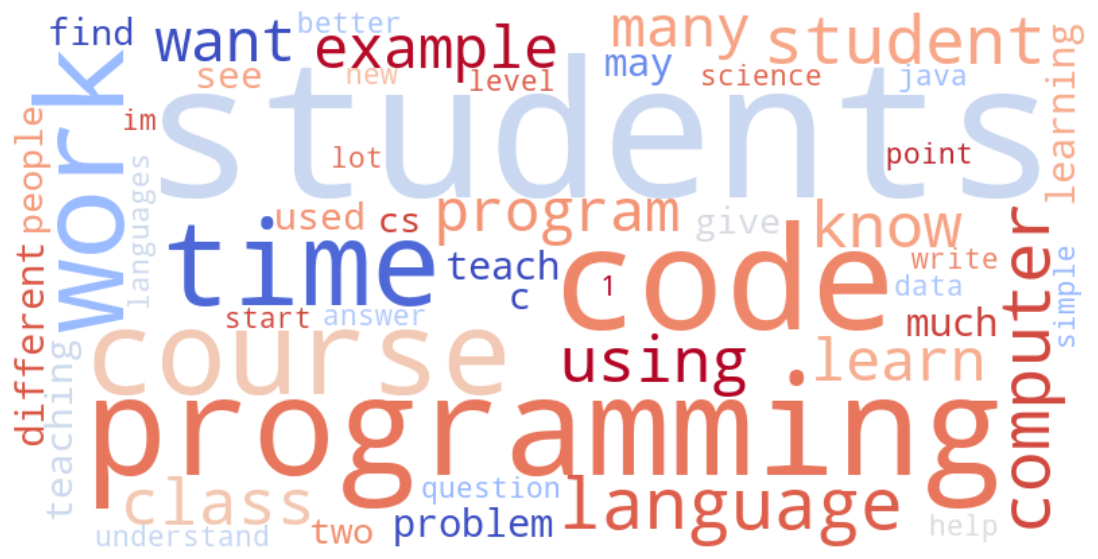

In [41]:
# making a dictionary of words
word_fre = dict(top_common)

# Making a wordcloud
wc = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate_from_frequencies(word_fre)

# Plot
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Now making a bar chart to show a bit more clearly the top 50 most common words (frequency) in the 'Body' column, after applying filtered stopwords

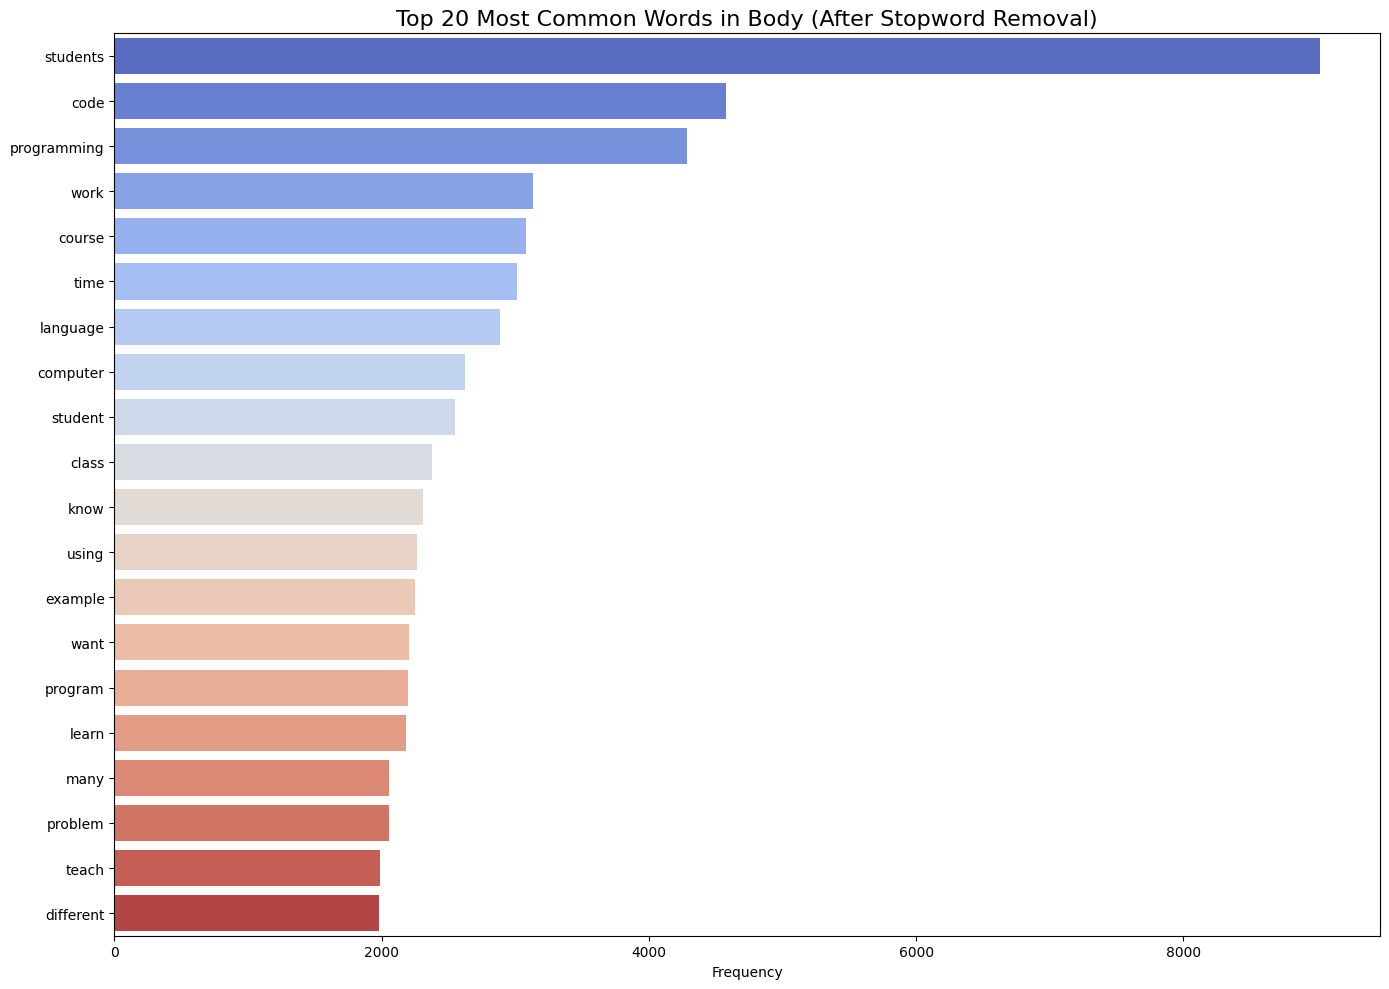

In [42]:
# Count all filtered tokens
all_filtered_body_tokens = [
    token.lower() for tokens in qa_df['BodyTokens']
    for token in tokens
    if token.lower() not in custom_stopwords
]

# Get top 20 most common
top_20 = Counter(all_filtered_body_tokens).most_common(20)

# Unpack into words and counts
words, counts = zip(*top_20)

# Build DataFrame
df_top20 = pd.DataFrame({'word': words, 'count': counts})

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(data=df_top20, x='count', y='word', hue='word', palette='coolwarm', dodge=False, legend=False)

plt.title('Top 20 Most Common Words in Body (After Stopword Removal)', fontsize=16)
plt.xlabel('Frequency')
plt.ylabel('')
plt.tight_layout()
plt.show()

* Quick check for chatgpt & autograding (Use this later) *

In [43]:
# Count occurrences of 'chatgpt' in Title and Body
chatgpt_title_count = qa_df['Title'].str.contains('chatgpt', case=False, na=False).sum()
chatgpt_body_count = qa_df['Body'].str.contains('chatgpt', case=False, na=False).sum()

# Count occurrences of 'LLM' in Title and Body
llm_title_count = qa_df['Title'].str.contains('llm', case=False, na=False).sum()
llm_body_count = qa_df['Body'].str.contains('llm', case=False, na=False).sum()

# Count occurrences of 'autograder'in Title and Body
autograder_title_count = qa_df['Title'].str.contains('autograder', case=False, na=False).sum()
autograder_body_count = qa_df['Body'].str.contains('autograder', case=False, na=False).sum()

print(f"ChatGPT mentioned in Title: {chatgpt_title_count}")
print(f"ChatGPT mentioned in Body: {chatgpt_body_count}")
print(f"LLM mentioned in Title: {llm_title_count}")
print(f"LLM mentioned in Body: {llm_body_count}")
print(f"Autograder mentioned in Title: {autograder_title_count}")
print(f"Autograder mentioned in Body: {autograder_body_count}")


ChatGPT mentioned in Title: 1
ChatGPT mentioned in Body: 19
LLM mentioned in Title: 2
LLM mentioned in Body: 43
Autograder mentioned in Title: 0
Autograder mentioned in Body: 23


Trying out some topic modelling with BERTopic

In [44]:
# Convert Titles
topic_titles = qa_df['Title'].astype(str).tolist()

# Create topic model for Title data
topic_model_titles = BERTopic()
topics_titles, probs_titles = topic_model_titles.fit_transform(topic_titles)


In [45]:
# Convert question bodies
topic_questions = qa_df['Body'].astype(str).tolist()

# Create topic model for body data
topic_model_body = BERTopic()
topics_body, probs_body = topic_model_body.fit_transform(topic_questions)


In [46]:
topic_model_titles.get_document_info(topic_titles)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,autograding software folks use java code,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
1,possible ensure division labor group assignment,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
2,objects lab inheritance polymorphism,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
3,teaching induction prove correctness algorithms,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
4,first programmingalgorithms class taught pseud...,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
...,...,...,...,...,...,...,...,...
6031,,166,166____,"[, , , , , , , , , ]","[, , ]",- - - - - - - - -,1.0,True
6032,create activities engineering students age ai,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
6033,learn coding learn era generative ai,0,0_programming_students_teaching_cs,"[programming, students, teaching, cs, computer...",[best book video lecture series follow object ...,programming - students - teaching - cs - compu...,1.0,False
6034,,116,116____,"[, , , , , , , , , ]","[, , ]",- - - - - - - - -,1.0,True


In [47]:
topic_model_body.get_document_info(topic_questions)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,grading currently either takes huge amount tim...,8,8_test_tests_testing_cases,"[test, tests, testing, cases, tdd, unit, code,...",[depends level student theres obviously big di...,test - tests - testing - cases - tdd - unit - ...,1.000000,False
1,lets say ive assigned intro cs class first gro...,19,19_team_pair_group_work,"[team, pair, group, work, teams, project, cont...",[assign students first team project instructio...,team - pair - group - work - teams - project -...,0.945423,False
2,finding difficult create lab objects java weve...,3,3_dog_public_interface_class,"[dog, public, interface, class, object, method...",[ideally interfaces come first classes interfa...,dog - public - interface - class - object - me...,0.616745,False
3,subject lot trouble clarifying students explai...,-1,-1_students_code_programming_one,"[students, code, programming, one, like, would...",[note like op teach high school things discuss...,students - code - programming - one - like - w...,0.000000,False
4,studying professors different approaches teach...,-1,-1_students_code_programming_one,"[students, code, programming, one, like, would...",[note like op teach high school things discuss...,students - code - programming - one - like - w...,0.000000,False
...,...,...,...,...,...,...,...,...
6031,relational programming prologue datalog kanren...,-1,-1_students_code_programming_one,"[students, code, programming, one, like, would...",[note like op teach high school things discuss...,students - code - programming - one - like - w...,0.000000,False
6032,looking ideas examples practical activities im...,-1,-1_students_code_programming_one,"[students, code, programming, one, like, would...",[note like op teach high school things discuss...,students - code - programming - one - like - w...,0.000000,False
6033,recently read post x andrew ng working course ...,56,56_people_programmer_job_skills,"[people, programmer, job, skills, large, code,...",[dont think question answered meaningful way i...,people - programmer - job - skills - large - c...,0.950961,False
6034,hard answer prediction unknown future likely c...,22,22_science_computer_digital_literacy,"[science, computer, digital, literacy, cs, sci...",[heres attempt answer reflections hopefully en...,science - computer - digital - literacy - cs -...,0.951406,False


These visualisations for the topic clusters for both 'Title' and 'Body' will nee cleaning up. I'm not sure if there is enough in the titles data for this to work, and the body data topic clusters will need to be labelled for future use I think ** Commented out code for now

In [48]:
# Testing with 'Title' data - commenting out so that the notebook doesn't get confusing
#topic_model_titles.visualize_barchart() # Too few topics? 

In [49]:
# Testiong with 'Body' data - commenting out so that the notebook doesn't get confusing
# topic_model_body.visualize_barchart(top_n_topics=50)

Combining both Title and Body topics seems to work better ** Commented out code for now

In [50]:
# Commenting out so it doesn't keep rerunning
# Original code - saved
combined_texts = (qa_df['Title'] + ". " + qa_df['Body']).astype(str).tolist()


topic_model_combined = BERTopic()

topics_combined, probs_combined = topic_model_combined.fit_transform(combined_texts)

This is the working model now, saved as original like model incase I need to try other models and return to this one

In [51]:
# This is now the working model and is saved for future use
topic_model_combined = BERTopic.load("bertopic_original_like_model")

In [52]:
topic_model_combined.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3486,-1_students_code_one_programming,"[students, code, one, programming, would, like...",[. note like op teach high school things discu...
1,0,138,0_students_student_dont_learn,"[students, student, dont, learn, learning, tea...",[. however every year find small number studen...
2,1,118,1_dog_public_interface_class,"[dog, public, interface, class, inheritance, m...",[. answer bit long give moderately sophisticat...
3,2,109,2_html_javascript_css_web,"[html, javascript, css, web, js, react, page, ...",[. ive thought using userscripts tool even fou...
4,3,95,3_names_analogy_naming_name,"[names, analogy, naming, name, box, metaphor, ...",[. usual explanation related names specificall...
...,...,...,...,...,...
77,76,12,76_automata_added_nfa_dfa,"[automata, added, nfa, dfa, turing, machines, ...",[. aware textbook online course within classro...
78,77,11,77_project_development_skills_something,"[project, development, skills, something, code...",[. ive software engineer 25 years opinion two ...
79,78,11,78_review_code_reviewer_reviews,"[review, code, reviewer, reviews, bowling, rev...",[motivate students review others code. code re...
80,79,10,79_abstraction_level_higher_languages,"[abstraction, level, higher, languages, langua...",[. come understanding question requires backgr...


In [53]:
# Seeing the topic clusters as bar charts for quick visibility - PRE COMBINING TOPICS
# topic_model_combined.visualize_barchart(top_n_topics=82)

In [54]:
# Model visualising the topics on a distance map - PRE COMBINING TOPICS
# topic_model_combined.visualize_topics()

In [55]:
# Model showing hierarchical clustering - PRE COMBINING TOPICS
# topic_model_combined.visualize_hierarchy()

In [56]:
topic_model_combined.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3486,-1_students_code_one_programming,"[students, code, one, programming, would, like...",[. note like op teach high school things discu...
1,0,138,0_students_student_dont_learn,"[students, student, dont, learn, learning, tea...",[. however every year find small number studen...
2,1,118,1_dog_public_interface_class,"[dog, public, interface, class, inheritance, m...",[. answer bit long give moderately sophisticat...
3,2,109,2_html_javascript_css_web,"[html, javascript, css, web, js, react, page, ...",[. ive thought using userscripts tool even fou...
4,3,95,3_names_analogy_naming_name,"[names, analogy, naming, name, box, metaphor, ...",[. usual explanation related names specificall...
...,...,...,...,...,...
77,76,12,76_automata_added_nfa_dfa,"[automata, added, nfa, dfa, turing, machines, ...",[. aware textbook online course within classro...
78,77,11,77_project_development_skills_something,"[project, development, skills, something, code...",[. ive software engineer 25 years opinion two ...
79,78,11,78_review_code_reviewer_reviews,"[review, code, reviewer, reviews, bowling, rev...",[motivate students review others code. code re...
80,79,10,79_abstraction_level_higher_languages,"[abstraction, level, higher, languages, langua...",[. come understanding question requires backgr...


The data visualisations show that several topics overlap and some are redundant. I will look through and see which topics can be combined to clean the model up a little bit.

1. Topics 41 + 72 (women, gender, female, girls)
2. Topics 65 + 50 (logic, boolean, algebra)
3. Topics 32 + 47 (git, guthub, version)

In [57]:
# Merge topics 41 & 72
topic_model_combined.merge_topics(
    docs=combined_texts,
    topics_to_merge=[41, 72]
)

# Merge topics 65 & 50
topic_model_combined.merge_topics(
    docs=combined_texts,
    topics_to_merge=[65, 50]
)

# Merge topics 32 & 47
topic_model_combined.merge_topics(
    docs=combined_texts,
    topics_to_merge=[32, 47]
)


In [58]:
topic_model_combined.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3486,-1_students_code_one_programming,"[students, code, one, programming, would, like...",[. note like op teach high school things discu...
1,0,138,0_students_student_dont_learn,"[students, student, dont, learn, learning, wor...",[. however every year find small number studen...
2,1,118,1_dog_public_interface_class,"[dog, public, interface, class, inheritance, m...",[. answer bit long give moderately sophisticat...
3,2,109,2_html_javascript_css_web,"[html, javascript, css, web, js, react, page, ...",[. ive thought using userscripts tool even fou...
4,3,95,3_names_analogy_naming_name,"[names, analogy, naming, name, box, metaphor, ...",[. usual explanation related names specificall...
...,...,...,...,...,...
74,73,12,73_automata_added_nfa_dfa,"[automata, added, nfa, dfa, turing, machines, ...",[. aware textbook online course within classro...
75,74,11,74_project_development_skills_something,"[project, development, skills, something, code...",[. ive software engineer 25 years opinion two ...
76,75,11,75_review_code_reviewer_reviews,"[review, code, reviewer, reviews, bowling, rev...",[motivate students review others code. code re...
77,76,10,76_abstraction_level_higher_languages,"[abstraction, level, higher, languages, langua...",[. come understanding question requires backgr...


In [59]:
topic_model_combined.get_topic_info().head(10)  # View top 10 by size

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3486,-1_students_code_one_programming,"[students, code, one, programming, would, like...",[. note like op teach high school things discu...
1,0,138,0_students_student_dont_learn,"[students, student, dont, learn, learning, wor...",[. however every year find small number studen...
2,1,118,1_dog_public_interface_class,"[dog, public, interface, class, inheritance, m...",[. answer bit long give moderately sophisticat...
3,2,109,2_html_javascript_css_web,"[html, javascript, css, web, js, react, page, ...",[. ive thought using userscripts tool even fou...
4,3,95,3_names_analogy_naming_name,"[names, analogy, naming, name, box, metaphor, ...",[. usual explanation related names specificall...
5,4,89,4_loop_loops_foreach_int,"[loop, loops, foreach, int, 10, condition, inf...",[. think much emphasis placed kind loop eg vs ...
6,5,84,5_degree_engineering_software_science,"[degree, engineering, software, science, cs, c...",[. think youre still slightly confused actuall...
7,6,79,6_recursion_recursive_disk_induction,"[recursion, recursive, disk, induction, card, ...",[respond students ask recursion good practice....
8,7,67,7_exam_questions_grading_labs,"[exam, questions, grading, labs, grade, points...",[. unfortunately exams kind advantage students...
9,8,65,8_plagiarism_code_student_cheating,"[plagiarism, code, student, cheating, students...",[. first straightforward accepted answer quest...


In [60]:
# Reprinting with fewer topics
topic_model_combined.visualize_barchart(top_n_topics=82) # Using higher number to make sure all topics are shown

In [61]:
# Reprinting with fewer topics
topic_model_combined.visualize_topics()

In [62]:
# Reprinting with fewer topics
topic_model_combined.visualize_hierarchy()

Now I want to visualise the topics over time

In [63]:
# Refitting because I've reduced the number of topics
topics_combined, probs_combined = topic_model_combined.fit_transform(combined_texts)

In [64]:
# Creating the topics over time 
topics_over_time = topic_model_combined.topics_over_time(
    docs=combined_texts,
    topics=topics_combined,
    timestamps=qa_df["CreationDate"],
    nr_bins=10
)

In [65]:
topic_model_combined.get_topic_info().head(11)  # View top 10 by size to check what I want to visualise here as all topics is messy

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3279,-1_students_code_programming_one,"[students, code, programming, one, like, would...",[. general overview updating java first genera...
1,0,183,0_science_degree_computer_cs,"[science, degree, computer, cs, engineering, s...",[. look required classes degree experience sof...
2,1,138,1_dog_public_interface_class,"[dog, public, interface, class, inheritance, o...",[. ideally interfaces come first classes inter...
3,2,102,2_students_student_learn_dont,"[students, student, learn, dont, learning, tea...",[. im afraid one sad true situations many stud...
4,3,102,3_html_javascript_css_web,"[html, javascript, css, web, js, react, page, ...",[. ive thought using userscripts tool even fou...
5,4,91,4_names_analogy_naming_metaphor,"[names, analogy, naming, metaphor, name, box, ...",[. usual explanation related names specificall...
6,5,86,5_plagiarism_code_student_students,"[plagiarism, code, student, students, cheating...",[. point award marks code complete producing o...
7,6,85,6_loop_loops_foreach_int,"[loop, loops, foreach, int, 10, condition, sta...",[. think much emphasis placed kind loop eg vs ...
8,7,83,7_exam_questions_labs_students,"[exam, questions, labs, students, grade, point...",[. unfortunately exams kind advantage students...
9,8,70,8_recursion_recursive_disk_iterative,"[recursion, recursive, disk, iterative, node, ...",[. think makes factorial fibonacci popular tea...


May need to rename some of the topics for clarity?

topic_model_combined.set_topic_labels({
    0: "CS Degrees & Curriculum Design",
    1: "OOP & Interfaces",
    2: "Naming Conventions & Teaching Analogies",
    3: "Web Development (HTML/CSS/JS)",
    4: "Student Learning Challenges",
    5: "Teaching Loops & Iteration",
    6: "Plagiarism & Academic Integrity",
    7: "Textbooks & Educational Resources",
    8: "Pointers & Memory Concepts",
    9: "Exams, Assessments & Practical Labs"
})

In [76]:
# Viewing topics over time (Top 10)
topic_model_combined.visualize_topics_over_time(
    topics_over_time,
    topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #custom_labels=True  # Making sure custom labels are used
)


Note: when looking at topics over time, it has re-shuffled the order of some of the topics - need to find out why

In [77]:
# Viewing topics over time (Top 5)
topic_model_combined.visualize_topics_over_time(
    topics_over_time,
    topics=[0, 1, 2, 3, 4],  # Viewing the top 5 topics by size
    #custom_labels=True  # Making sure custom labels are used
)

In [ ]:
# Adding topics (numbers) to orignal dataframe if needed later on for referencing
qa_df["Topic"] = topics_combined

SUMMARY NOTES FOR REFERENCE

In [71]:
# Run head for reference
qa_df.head()

,Id,PostTypeId,ParentId,Title,Body,CommentCount,ViewCount,AnswerCount,Score,Tags,CreationDate,TitleTokens,BodyTokens,Topic
0,2,1,NaN,autograding software folks use java code,grading currently either takes huge amount tim...,9,5402.0,8.0,26,"[java, grading, auto-graders]",2017-05-23,"[autograding, software, folks, use, java, code]","[grading, currently, either, takes, huge, amou...",22
1,3,1,NaN,possible ensure division labor group assignment,lets say ive assigned intro cs class first gro...,1,602.0,4.0,10,[group-work],2017-05-23,"[possible, ensure, division, labor, group, ass...","[lets, say, ive, assigned, intro, cs, class, f...",17
2,4,1,NaN,objects lab inheritance polymorphism,finding difficult create lab objects java weve...,3,712.0,11.0,9,"[object-oriented-paradigm, labs, ap-computer-s...",2017-05-23,"[objects, lab, inheritance, polymorphism]","[finding, difficult, create, lab, objects, jav...",1
3,6,1,NaN,teaching induction prove correctness algorithms,subject lot trouble clarifying students explai...,1,413.0,3.0,8,"[lesson-ideas, cs-theory, induction]",2017-05-23,"[teaching, induction, prove, correctness, algo...","[subject, lot, trouble, clarifying, students, ...",8
4,7,1,NaN,first programmingalgorithms class taught pseud...,studying professors different approaches teach...,7,1404.0,9.0,22,[pseudo-code],2017-05-23,"[first, programmingalgorithms, class, taught, ...","[studying, professors, different, approaches, ...",26


In [72]:
# Look at core stats again
qa_df.describe().round(2)

,Id,PostTypeId,ParentId,CommentCount,ViewCount,AnswerCount,Score,CreationDate,Topic
count,6036.00,6036.00,4786.00,6036.00,1250.00,1250.00,6036.00,6036,6036.00
mean,4422.56,1.79,4016.00,2.31,1557.99,3.83,5.37,2019-03-29 02:43:25.168986112,9.65
min,2.00,1.00,2.00,0.00,7.00,0.00,-5.00,2017-05-23 00:00:00,-1.00
25%,2827.75,2.00,1408.00,0.00,138.00,1.00,1.00,2017-07-21 00:00:00,-1.00
50%,4636.50,2.00,4211.00,1.00,266.00,3.00,3.00,2018-04-17 00:00:00,-1.00
75%,6419.25,2.00,6005.00,3.00,743.00,5.00,6.00,2020-07-06 00:00:00,13.00
max,8237.00,2.00,8227.00,42.00,108964.00,31.00,229.00,2025-03-27 00:00:00,77.00
std,2375.61,0.41,2454.42,3.36,4945.94,3.95,10.33,NaN,18.05


In [73]:
# Looking at content of the most viewed post for the report later on
top_viewed_post = qa_df.loc[qa_df['ViewCount'].idxmax()]
print("Title:", top_viewed_post['Title'])
print("\nBody:", top_viewed_post['Body'])
print("\nViewCount:", top_viewed_post['ViewCount'])
print("\nTopic ID:", top_viewed_post['Topic'])

Title: teach 1 kb 1024 bytes 1000 bytes

Body: conversion teach undergrad students 1 kb 1024 bytes binary everyone learned back nineties recent industryled friendly conversion says 1 kb fact 1000 bytes decimal immediate feeling goes toward binary conversion iec says otherwise major oss decide decimal conversion mac os x ≥ 106 ubuntu ≥ 1010 use si prefixes exclusively refer powers 1000 im sure anymore

ViewCount: 108964.0

Topic ID: 62


In [74]:
# Looking at content of the highest scoring post for the report later on
top_scoring_post = qa_df.loc[qa_df['Score'].idxmax()]
print("Title:", top_scoring_post['Title'])
print("\nBody:", top_scoring_post['Body'])
print("\nScore:", top_scoring_post['Score'])
print("\nTopic ID:", top_scoring_post['Topic'])

Title: 

Body: none reasons suggest really get heart use zeroindexing cs dijkstras ewd831 explains convention works best comes fact want represent sequences integers halfopen intervals inclusive start side denote subsequence natural numbers 2 3 12 without pernicious three dots four conventions open us 2 ≤ 13 b 1 ≤ 12 c 2 ≤ ≤ 12 1 13 paraphrase dijkstra b advantage subtracting bounds gives length convenient dont need remember add subtract 1 c advantage sequences starting zero dont need negative lower bound negatives longer natural numbers advantage create interval starts zero shrink zerolength dont need negative upper bound want write intervals accept correct way specifying intervals indexing array length n 0 n much nicer 1 n1 two additional notes favor using intervals first point important halfopen intervals nicely decompose halfopen intervals makes implementing divideandconquer algorithms like merge sort significantly less error prone example 4 14 broken equalsized intervals 4 9 9 14 

Fuller text (pre cleaning for analysis)

Title: should i teach that 1 kb = 1024 bytes or 1000 bytes?

Body: which conversion should i teach to my undergrad students? that 1 kb is 1024 bytes (binary) as everyone learned back in the nineties or the recent industry-led "friendly" conversion that says that 1 kb is in fact 1000 bytes (decimal)?
my immediate feeling goes toward the binary conversion, but when iec says otherwise and major oss decide for the decimal conversion (mac os x ≥ 10.6 and ubuntu ≥ 10.10 now use the si prefixes exclusively to refer to powers of 1000) i'm not so sure anymore. 


ViewCount: 108964.0


Title: 

Body: none of the reasons you suggest really get to the heart of why we use zero-indexing in cs. dijkstra's ewd831 explains why this convention works out the best. it comes down to the fact that we want to represent sequences of integers as half-open intervals that are inclusive on the start side.

to denote the subsequence of natural numbers 2, 3, ..., 12 without the pernicious three dots, four conventions are open to us
  a) 2 ≤ i < 13
  b) 1 < i ≤ 12
  c) 2 ≤ i ≤ 12
  d) 1 < i < 13

to paraphrase dijkstra:

(a) and (b) have the advantage that subtracting the bounds gives you the length, which is convenient because you don't need to remember to add or subtract 1.
(a) and (c) have the advantage that sequences starting with zero don't need a negative lower bound -- and negatives are no longer natural numbers.
(a) and (d) have the advantage that if you create an interval that starts with zero and shrink it down to zero-length, you don't need a negative for the upper bound.

because of the above, we want to write all of our intervals as (a).
once you accept that (a) is the correct way of specifying intervals, indexing an array of length n as [0, n) is much nicer than [1, n+1).
...
as for how to explain the above to your students, i think that they just need to accept that breaking sequences of integers in half is something they'll do later on, and then a few examples will quickly point to [,) intervals and zero indexing as the most natural choice.


Score: 229

Ready to start moving findings over to written report - will come back to notebook for ad-hoc analysis and visualisations